In [33]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import random as rd
import sys

sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import PerturbedPendulum_Methods as pp

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [34]:
file = open("x_train.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()

x = []
y = []

read_x = open("x_train.txt", "r")
read_y = open("y_train.txt", "r")
read_z = open("z_train.txt", "r")

for i in range(int(line_count)):

    x.append([float(read_x.readline()), float(read_y.readline()), float(read_z.readline())])

read_x.close()
read_y.close()
read_z.close()

print("Number of points: ", len(x))

Number of points:  20001


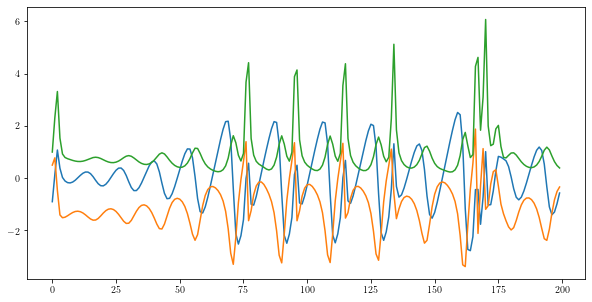

In [35]:
plt.figure(figsize=(10,5))
plt.plot(x[:200])
plt.show()

In [36]:
x_train = np.array(x[0:-1])
x_train = x_train.astype(np.float32)

y_train = np.array(x[1:])
y_train = y_train.astype(np.float32)

val_len = 1000

x_val = x_train[-val_len:]
y_val = y_train[-val_len:]

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(1000)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(20000)

In [37]:
class MLP(tf.keras.layers.Layer):
    
    def __init__(self):
        super(MLP, self).__init__()


    def build(self, input_shape):
        
        
        self.L1 = tf.keras.layers.Dense(50, activation='tanh')
        self.L2 = tf.keras.layers.Dense(50, activation='tanh')
        self.L3 = tf.keras.layers.Dense(3, activation='tanh')
        
    def call(self, inputs, training=False):
        
        h = self.L1(inputs)
        h = self.L2(h)
        h = self.L3(h)
        
        return h

In [38]:
class shift(tf.keras.layers.Layer):
    
    def __init__(self):

        super(shift, self).__init__()

    def build(self, input_shape):
        
        self.w = self.add_weight(
            name='w',
            shape=(3,),
            initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
            trainable = True
            )
            
        self.b = self.add_weight(
            name='b',
            shape=(3,),
            initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
            trainable = True
            )


    def call(self, inputs, training=False):
        
        return self.w*inputs + self.b

In [39]:
def get_shift_and_log_scale_resnet(input_shape, blocks, shift):
    
    inputs = tf.keras.Input(shape=input_shape)
    h = inputs

    for block in blocks:
        h = block(h)

    shift, log_scale = shift(inputs), h
    log_scale = tf.math.tanh(log_scale)
    return Model(inputs=inputs, outputs=[shift, log_scale], name='name')

In [17]:
class AffineCouplingLayer(tfb.Bijector):

    def __init__(self, shift_and_log_scale_fn, mask, **kwargs):
        super(AffineCouplingLayer, self).__init__(
            forward_min_event_ndims=1, **kwargs)
        self.shift_and_log_scale_fn = shift_and_log_scale_fn
        self.b = tf.cast(mask, tf.float32)

    def _forward(self, x):
        t, log_s = self.shift_and_log_scale_fn(x * self.b)
        y = self.b * x + (1 - self.b) * (x * tf.exp(log_s) + t)
        return y

    def _inverse(self, y):
        t, log_s = self.shift_and_log_scale_fn(y * self.b)
        x = self.b * y + (1 - self.b) * ((y - t) * tf.exp(-log_s))
        return x

In [18]:
class R(tf.keras.layers.Layer):

    def __init__(self):
        super(R, self).__init__()
        
    def call(self, inputs):
        return inputs*tf.constant([[-1., -1., -1.]])

In [19]:
class RealNVPModel(tf.keras.Model):
    
    def __init__(self, shift_and_log_scale, **kwargs):
        
        super(RealNVPModel, self).__init__()
        self.R = R()
        masks = []
        self.l = []
        
        for j in range(len(shift_and_log_scale)):
            
            if j%3==0:
                masks.append(tf.constant([[0., 1., 1.]]))
            if j%3==1:
                masks.append(tf.constant([[1., 0., 1.]]))
            else:
                masks.append(tf.constant([[1., 1., 0.]]))
        
        for i,j in zip(shift_and_log_scale, masks):
            self.l.append(AffineCouplingLayer(i, j))
        

    def call(self, input_tensor):
        
        a = self.R(input_tensor)
        
        for layer in self.l:
            a = layer._forward(a)

        a = self.R(a)

        for layer in self.l[::-1]:
            a = layer._inverse(a)
        
        return a

In [20]:
num_blocks = 5

blocks = [MLP() for i in range(num_blocks)]

shifts = [shift() for i in range(len(blocks))]

shift_and_log_scale = [get_shift_and_log_scale_resnet((3), [i], j) for i,j in zip(blocks, shifts)]

In [21]:
shift_and_log_scale[0].summary()

Model: "name"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
mlp (MLP)                       (None, 3)            2903        input_1[0][0]                    
__________________________________________________________________________________________________
shift (shift)                   (None, 3)            6           input_1[0][0]                    
__________________________________________________________________________________________________
tf.math.tanh (TFOpLambda)       (None, 3)            0           mlp[0][0]                        
Total params: 2,909
Trainable params: 2,909
Non-trainable params: 0
___________________________

In [22]:
model = RealNVPModel(shift_and_log_scale)

In [23]:
# DECAYING LEARNING RATE
def scheduler(epoch, lr):
    if epoch < 5:
        print(lr)
        return lr
    else:
        #print(lr)
        return lr*tf.math.exp(-0.0002)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

0.002
0.002
0.002
0.002
0.002


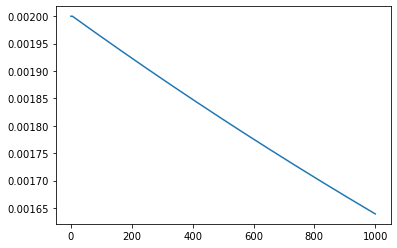

In [24]:
lr = [0.002]
for i in range(1000):
    lr.append(scheduler(i, lr[-1]))

plt.plot(lr)
plt.show()

In [25]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #loss = custom_loss,
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=tf.keras.optimizers.Adam(0.002), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [26]:
history = model.fit(train_dataset, epochs = 100, callbacks = [callback], verbose=0) #np.array(x), [np.array(y),a,a]

0.0020000000949949026
0.0020000000949949026
0.0020000000949949026
0.0020000000949949026
0.0020000000949949026


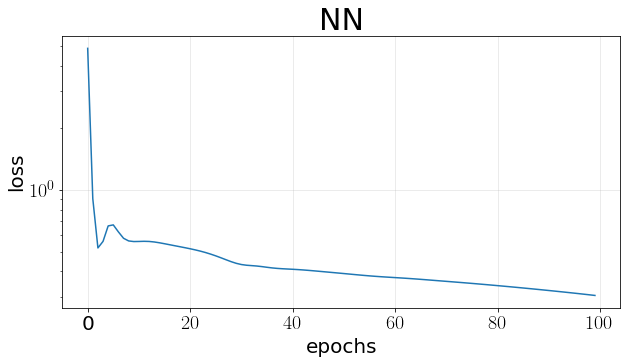

In [27]:
plt.figure(figsize = (10,5))
#plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'NN', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

In [28]:
x0 = x_train[100]

f_iterations = [model(x0)]

In [30]:
for _ in range(200):
    f_iterations.append(model(f_iterations[-1]))

#b_iterations = [f_iterations[-1]*np.array([[-1., -1., -1.]])]

#for _ in range(100):
    #b_iterations.append(model(b_iterations[-1]))

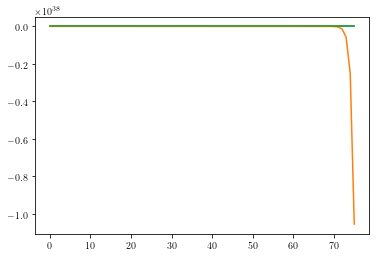

In [31]:
plt.plot([i[0].numpy() for i in f_iterations])

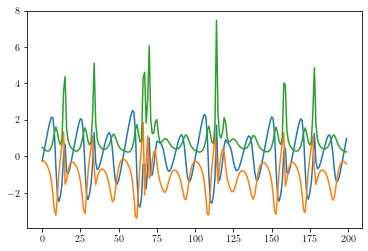

In [32]:
plt.plot(x_train[100:300])